### Preprocessing

In [2]:
# import packages
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import os

# sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import feature_extraction
from sklearn import svm, metrics, ensemble
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.inspection import permutation_importance

In [ ]:
# Parameter adjustment
seed = 42  # random state
test_size = 0.2  # test sample size

In [3]:
df = pd.read_json("/Users/deankuo/Desktop/python/DSSI_Final_project/591housing_tokenization_others.json") # TF-IDF dataset
df1 = pd.read_json("/Users/deankuo/Desktop/python/DSSI_Final_project/district.json") # District dataset
df1 = df1.rename(columns={"地址": "district_group"}).drop("index", axis=1) # Change column name and drop index
district = df1.to_numpy()
df.head(5)


,房價,坪數,price_per_size,冰箱,洗衣機,電視,冷氣,熱水器,床,衣櫃,第四台,網路,天然瓦斯,沙發,桌椅,陽台,電梯,車位,All_token
0,29500,15.00,1966.666667,1,1,0,1,1,1,1,0,1,0,1,1,0,0,0,"[可住, 可辦, 管理, 中山區, 最短, 租期, 一年, 隨時, 遷入, 不可, 養, 寵..."
1,65000,42.95,1513.387660,1,1,1,0,0,1,1,0,0,0,0,1,1,0,1,"[獨棟, 仁愛, 品藏, 電梯, 優質, 二房, 加, 車位, 大安區, 最短, 租期, 一..."
2,39000,17.00,2294.117647,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,"[義大利, 設計, 宅大, 空間, 樓中樓, 含, 停車位, 信義區, 最短, 租期, 一年..."
3,11500,6.50,1769.230769,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,"[台大, 北教大, 溫馨, 麗緻, 雅房, 優選, 好屋, 大安區, 最短, 租期, 一年,..."
4,12800,12.00,1066.666667,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,"[師大, 商圈, 靜巷, 採光宅, 大安區, 最短, 租期, 一年, 隨時, 遷入, 房屋,..."


In [4]:
# I define houses that price_per_size > 1800 as expensive house and code it as 1
df.insert(2, column="district", value=district) 
df.insert(3, column="expensive_house", value=(df["price_per_size"] >= 1800).astype(int)) 
df["price_per_size"] = df["price_per_size"].round() # 四捨五入
print(f'Total number of houses that is more expensive than threshold: {df["expensive_house"].sum()}')  


Total number of houses that is more expensive than threshold: 4795


In [5]:
print(f'The average price per ping is: {df["price_per_size"].mean().round()}') # type: ignore

The average price per ping is: 1714.0


In [6]:
# 因為先前有將無效資料drop掉，但沒有處理到index，所以在這邊重新整理一次index
df.set_index("expensive_house", inplace=True)
df.reset_index(inplace=True)
df.head(5)

,expensive_house,房價,坪數,district,price_per_size,冰箱,洗衣機,電視,冷氣,熱水器,...,衣櫃,第四台,網路,天然瓦斯,沙發,桌椅,陽台,電梯,車位,All_token
0,1,29500,15.00,中山區,1967.0,1,1,0,1,1,...,1,0,1,0,1,1,0,0,0,"[可住, 可辦, 管理, 中山區, 最短, 租期, 一年, 隨時, 遷入, 不可, 養, 寵..."
1,0,65000,42.95,大安區,1513.0,1,1,1,0,0,...,1,0,0,0,0,1,1,0,1,"[獨棟, 仁愛, 品藏, 電梯, 優質, 二房, 加, 車位, 大安區, 最短, 租期, 一..."
2,1,39000,17.00,信義區,2294.0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,"[義大利, 設計, 宅大, 空間, 樓中樓, 含, 停車位, 信義區, 最短, 租期, 一年..."
3,0,11500,6.50,大安區,1769.0,1,1,1,1,1,...,1,1,1,1,0,1,0,0,0,"[台大, 北教大, 溫馨, 麗緻, 雅房, 優選, 好屋, 大安區, 最短, 租期, 一年,..."
4,0,12800,12.00,大安區,1067.0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,"[師大, 商圈, 靜巷, 採光宅, 大安區, 最短, 租期, 一年, 隨時, 遷入, 房屋,..."


### TF-IDF

In [7]:
# 取得各房屋敘述的token
test_document = [" ".join(doc) for doc in df.All_token]

# Vectorization
vec = TfidfVectorizer(max_df=0.99, min_df=0.005) # type: ignore
X = vec.fit_transform(test_document)
tfidf_data = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out()) # type: ignore
tfidf_data.shape # dataframe shape

(12213, 1736)

In [8]:
# District data
tfidf_district_data = pd.concat([df1, df.expensive_house, df.price_per_size, tfidf_data], axis=1)
tfidf_district_data.head(5)

,district_group,expensive_house,price_per_size,10f,11f,12f,13f,14f,15f,16f,...,麥當勞,麻煩,黃先生,黃慶雄,黃金,黃金地段,點交,點開,齊全,龍山寺
0,中山區,1,1967.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,大安區,0,1513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,信義區,1,2294.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,大安區,0,1769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,大安區,0,1067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### District Classification

In [9]:
# Data overview
Counter(tfidf_district_data["district_group"])

Counter({'中山區': 2248,
         '大安區': 1794,
         '信義區': 1382,
         '松山區': 946,
         '北投區': 604,
         '內湖區': 1154,
         '中正區': 778,
         '大同區': 699,
         '文山區': 518,
         '萬華區': 642,
         '南港區': 436,
         '士林區': 1012})

In [31]:
# Define models
models = {
    "Linear_SVM": svm.SVC(C=1, kernel="linear"),
    "RBF_SVM": svm.SVC(C=10, kernel="rbf"),
    "Bernoulli_NB": BernoulliNB(alpha=0.1),
    "Random_Forest": RandomForestClassifier(n_estimators=800),
}

# Define groupby object and keys
grouped_by_district = tfidf_district_data.groupby(["district_group"])
district_keys = grouped_by_district.groups.keys()

# Define function for model process
def process_model(model, file_name):
    precision_list, recall_list, f1_list, district_list = [], [], [], []

    # Iterate models through districts
    for district_key in district_keys:
        district_data = grouped_by_district.get_group(district_key)
        X = district_data.drop(["expensive_house", "district_group", "price_per_size"], axis=1)
        y = district_data["expensive_house"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        district_list.append(district_key)

    # Save dataframe
    df = pd.DataFrame({"District": district_list, "Precision": precision_list, "Recall": recall_list, "F1 Score": f1_list})
    df.set_index("District", inplace=True)
    return df

# Iterate models and create reports
precision_df, recall_df, f1score_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for name, model in models.items():
    df = process_model(model, name)
    precision_df[f"{name} Precision"] = df["Precision"]
    recall_df[f"{name} Recall"] = df["Recall"]
    f1score_df[f"{name} F1 Score"] = df["F1 Score"]


/Users/deankuo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
precision_df

,Linear_SVM Precision,RBF_SVM Precision,Bernoulli_NB Precision,Random_Forest Precision
District,,,,
中山區,0.662037,0.718593,0.677419,0.702970
中正區,0.535211,0.677966,0.474576,0.636364
信義區,0.790909,0.773913,0.728814,0.764151
內湖區,0.714286,0.677419,0.506494,0.789474
北投區,1.000000,0.714286,0.538462,1.000000
南港區,0.642857,0.631579,0.520000,0.533333
士林區,0.416667,0.428571,0.358209,0.454545
大同區,0.829787,0.857143,0.800000,0.878049
大安區,0.712707,0.767442,0.679245,0.751412


In [33]:
recall_df

,Linear_SVM Recall,RBF_SVM Recall,Bernoulli_NB Recall,Random_Forest Recall
District,,,,
中山區,0.655963,0.655963,0.577982,0.651376
中正區,0.622951,0.655738,0.459016,0.573770
信義區,0.644444,0.659259,0.637037,0.600000
內湖區,0.342466,0.575342,0.534247,0.410959
北投區,0.176471,0.294118,0.411765,0.176471
南港區,0.333333,0.444444,0.481481,0.296296
士林區,0.102041,0.367347,0.489796,0.204082
大同區,0.609375,0.656250,0.625000,0.562500
大安區,0.704918,0.721311,0.590164,0.726776


In [34]:
f1score_df

,Linear_SVM F1 Score,RBF_SVM F1 Score,Bernoulli_NB F1 Score,Random_Forest F1 Score
District,,,,
中山區,0.658986,0.685851,0.623762,0.676190
中正區,0.575758,0.666667,0.466667,0.603448
信義區,0.710204,0.712000,0.679842,0.672199
內湖區,0.462963,0.622222,0.520000,0.540541
北投區,0.300000,0.416667,0.466667,0.300000
南港區,0.439024,0.521739,0.500000,0.380952
士林區,0.163934,0.395604,0.413793,0.281690
大同區,0.702703,0.743363,0.701754,0.685714
大安區,0.708791,0.743662,0.631579,0.738889


### Model Selection of Taipei City

In [ ]:
# Train test split
y = tfidf_district_data["expensive_house"]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# SVM , Naive Bayes, and Random Forest model
models = {
    "Linear SVM": svm.SVC(C=1, kernel='linear'), # linear SVM
    "RBF SVM": svm.SVC(C=1, kernel='rbf'), # RBF SVM
    "Bernoulli Naive Bayes": BernoulliNB(alpha=1), # Bernoulli Naive Bayes
    "Random Forest": RandomForestClassifier(n_estimators=100), # Random Forest
}

results = {}
results_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score'])

for model_name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    report = metrics.classification_report(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    # Model results
    results[model_name] = {
        "precision": precision,
        "recall": recall,
        "f1 score": f1,
        "report": report,
        "confusion_matrix": confusion_matrix,
    }
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=[0])], ignore_index=True)

for model, data in results.items():
    print(f"Classification report of model: {model}")
    print(data['report'])
    print(f"Confusion matrix of model: {model}")
    print(data['confusion_matrix'], end="\n")

In [43]:
results_df.set_index('Model', inplace=True)

,Model,Precision,Recall,F1 Score
0,Linear SVM,0.679204,0.614615,0.645297
1,RBF SVM,0.719905,0.604605,0.657236
2,Bernoulli Naive Bayes,0.573115,0.631632,0.600952
3,Random Forest,0.754226,0.580581,0.656109


In [44]:
def hyperparameter_tuning(X_train=X_train, y_train=y_train, X_test=X_test):
    # Define parameter grids
    svm_linear_params = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}
    svm_rbf_params = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']}
    random_forest_params = {'n_estimators': [50, 100, 200, 400, 800]}
    naive_bayes_params = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

    # Define models
    svm_linear = SVC()
    svm_rbf = SVC()
    random_forest = RandomForestClassifier()
    naive_bayes = BernoulliNB()

    # Create parameter grid dictionary
    param_grid = {'svm_linear': svm_linear_params, 'svm_rbf': svm_rbf_params, 
                  'random_forest': random_forest_params, 'naive_bayes': naive_bayes_params}

    # Create model dictionary
    models = {'svm_linear': svm_linear, 'svm_rbf': svm_rbf, 
              'random_forest': random_forest, 'naive_bayes': naive_bayes}

    # Create results dictionary
    results = {}
    y_pred = {}

    # Iterate over models and perform hyperparameter tuning
    for name, model in models.items():
        print(f"Performing hyperparameter tuning for {name}...")

        # Create GridSearchCV object
        grid_search = GridSearchCV(model, param_grid[name], scoring='f1', cv=5, verbose=3)

        # Fit the model with GridSearchCV
        grid_search.fit(X_train, y_train)

        # Save the best parameters and best f1 score
        results[name] = {'best_params': grid_search.best_params_, 
                         'best_score': grid_search.best_score_}

        # Y prediction
        y_pred[name] = grid_search.predict(X_test)

    return results, y_pred

results, y_pred = hyperparameter_tuning()


Performing hyperparameter tuning for svm_linear...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.000 total time=  42.2s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.000 total time=  43.1s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.000 total time=  41.8s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.000 total time=  41.8s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.000 total time=  41.6s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.508 total time=  41.4s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.475 total time=  41.3s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.485 total time=  41.7s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.485 total time=  42.0s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.481 total time=  37.5s
[CV 1/5] END ................C=1, kernel=linear;, score=0.649 total time=  32.9

In [45]:
results

{'svm_linear': {'best_params': {'C': 1, 'kernel': 'linear'},
  'best_score': 0.6417481835094694},
 'svm_rbf': {'best_params': {'C': 10, 'kernel': 'rbf'},
  'best_score': 0.6716980921935052},
 'random_forest': {'best_params': {'n_estimators': 400},
  'best_score': 0.6193349653033906},
 'naive_bayes': {'best_params': {'alpha': 0.1},
  'best_score': 0.6105767546172929}}

In [46]:
optimal_clf = SVC(C=10, kernel='rbf')
optimal_clf.fit(X_train, y_train)
optimal_pred = optimal_clf.predict(X_test)
report = classification_report(y_test, optimal_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1444
           1       0.73      0.68      0.70       999

    accuracy                           0.76      2443
   macro avg       0.76      0.75      0.75      2443
weighted avg       0.76      0.76      0.76      2443



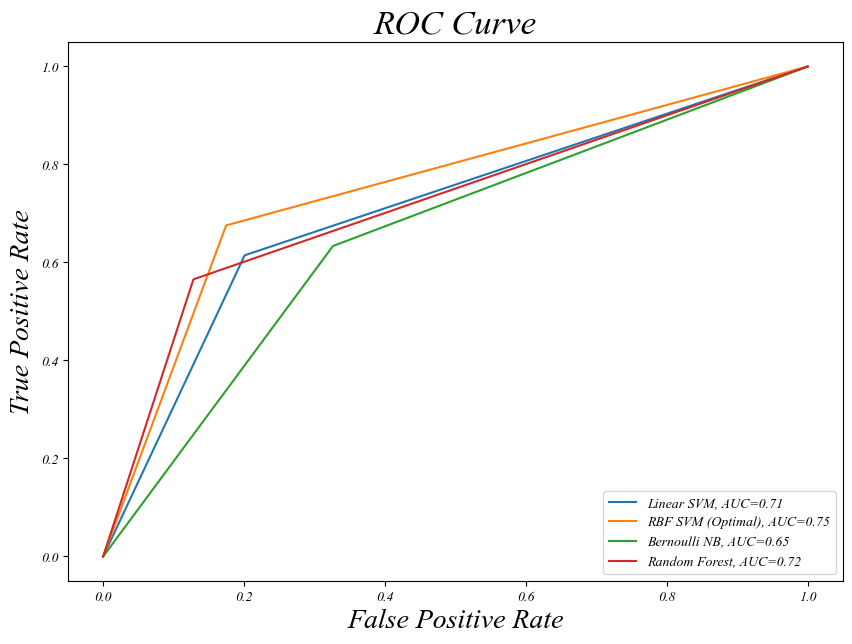

In [47]:
# Plotting ROC curve
plt.rcParams['font.family'] = ['Times New Roman']
plt.rcParams['font.style'] = 'italic'

plt.figure(figsize=(10,7))

models = {
    'Linear SVM': y_pred['svm_linear'],
    'RBF SVM (Optimal)': y_pred['svm_rbf'],
    'Bernoulli NB': y_pred['naive_bayes'],
    'Random Forest': y_pred['random_forest']
}

for model, y_pred in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{model}, AUC={auc:.2f}")

plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.title("ROC Curve", fontsize=25)
plt.legend(loc='lower right')
plt.savefig("ROC_curve.jpg", dpi=500)